In [1]:
import numpy as np
import pandas as pd # data frame
import matplotlib.pyplot as plt # visualization
import seaborn as sns # visualization
import tqdm as tqdm
import PIL
from PIL import Image, ImageOps
import cv2
import glob

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
from sklearn.model_selection import train_test_split

import albumentations as A
from albumentations.pytorch import ToTensorV2

plt.style.use('seaborn')
# sns.set(font_scale=2.5)

import missingno as msno # null data를 보여줌

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
df_train = pd.read_csv('input/data/train/train.csv')

In [3]:
df_train.head()

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59


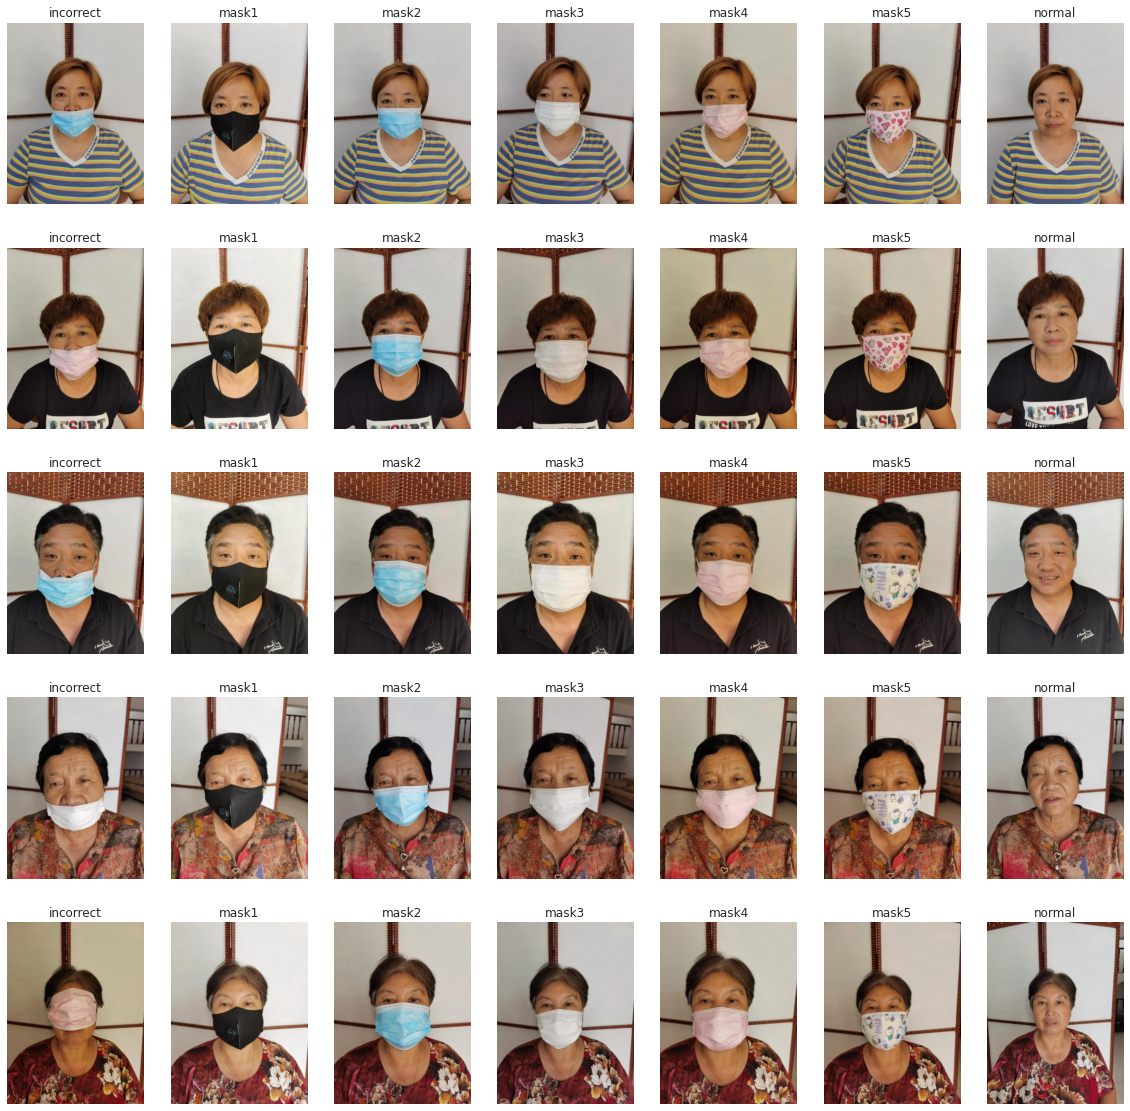

In [4]:
f = plt.figure(figsize=(20, 20))
for idx, pth in enumerate(df_train['path'].head()):
    ax = f.add_subplot(5, 7, idx*7+1, xticks=[], yticks=[])
    img = cv2.imread(f"input/data/train/images/{pth}/incorrect_mask.jpg")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.set_title('incorrect')
    ax.imshow(img)

    for i in range(1, 6):
        ax = f.add_subplot(5, 7, idx*7+i+1, xticks=[], yticks=[])
        img = cv2.imread(f"input/data/train/images/{pth}/mask{i}.jpg")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.set_title(f"mask{i}")
        ax.imshow(img)        
    
    ax = f.add_subplot(5, 7, idx*7+7, xticks=[], yticks=[])
    img = cv2.imread(f"input/data/train/images/{pth}/normal.jpg")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.set_title('normal')
    ax.imshow(img)
    
plt.show()

#### id와 race는 class를 구분하는 데 영향을 주지 않을 가능성이 높으므로 삭제해준다.

In [5]:
df_train = df_train.drop(['id', 'race'], axis=1)

In [6]:
df_train

,gender,age,path
0,female,45,000001_female_Asian_45
1,female,52,000002_female_Asian_52
2,male,54,000004_male_Asian_54
3,female,58,000005_female_Asian_58
4,female,59,000006_female_Asian_59
...,...,...,...
2695,male,19,006954_male_Asian_19
2696,male,19,006955_male_Asian_19
2697,male,19,006956_male_Asian_19
2698,male,20,006957_male_Asian_20


### Gender

In [7]:
df_train.loc[(df_train['gender'] == 'male'), 'gender'] = 0
df_train.loc[(df_train['gender'] == 'female'), 'gender'] = 1

In [8]:
print('Num of Male:', len(df_train[df_train['gender'] == 0]))
print('Num of Female:', len(df_train[df_train['gender'] == 1]))

Num of Male: 1042
Num of Female: 1658


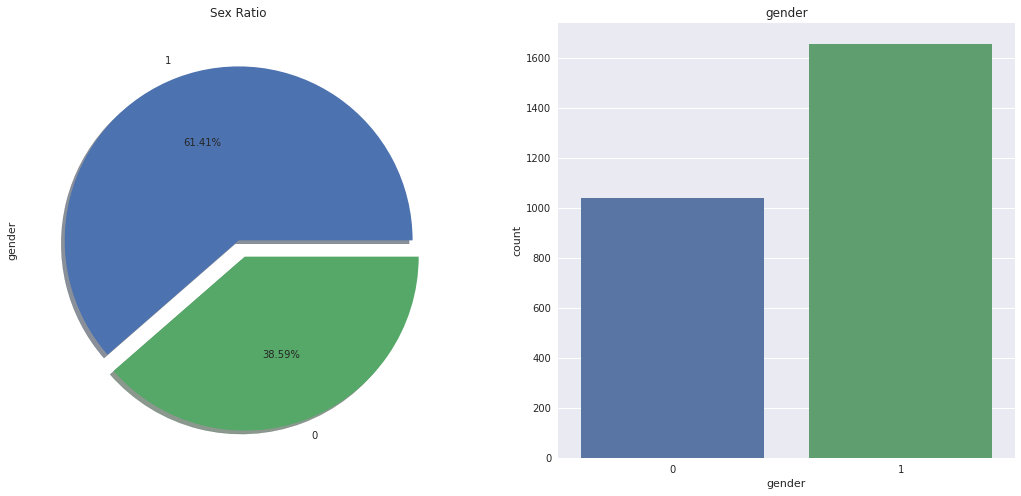

In [9]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))
df_train['gender'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.2f%%', shadow=True, ax=ax[0])
ax[0].set_title('Sex Ratio')

sns.countplot('gender', data=df_train, ax=ax[1])
ax[1].set_title('gender')

plt.show()

### Age

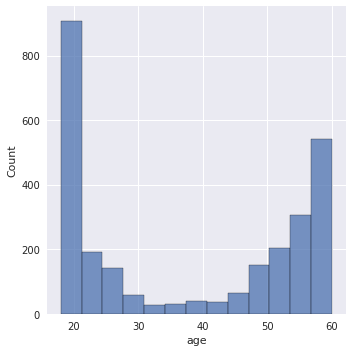

In [10]:
sns.displot(df_train['age'])

### Age & Gender

In [11]:
pd.crosstab(df_train['age'], df_train['gender']).style.background_gradient(cmap='summer_r')

gender,0,1
age,,
18,41,151
19,207,200
20,80,187
21,27,14
22,37,21
23,40,32
24,31,31
25,35,47
26,27,17


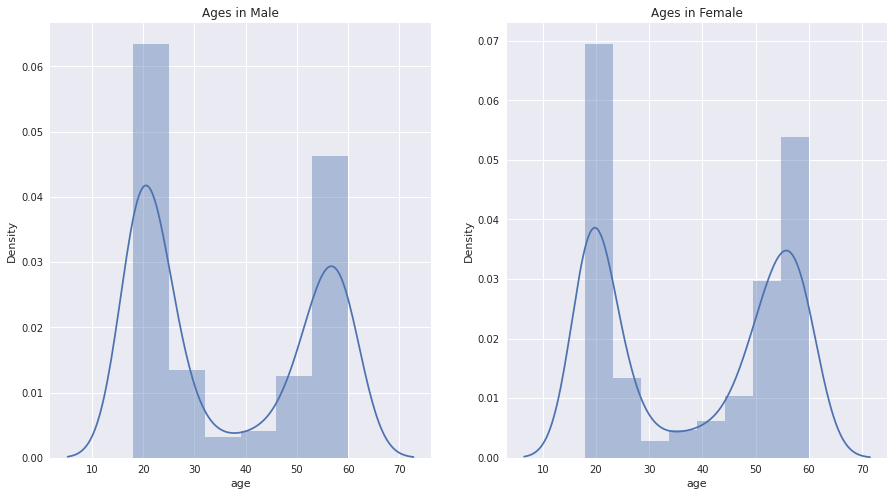

In [12]:
f, ax = plt.subplots(1, 2, figsize=(15, 8))
sns.distplot(df_train[df_train['gender'] == 0].age, ax=ax[0])
ax[0].set_title('Ages in Male')

sns.distplot(df_train[df_train['gender'] == 1].age, ax=ax[1])
ax[1].set_title('Ages in Female')

plt.show()

In [13]:
train_data = pd.DataFrame()
for i, row in df_train.iterrows():
    # Incorrect
    row['path'] = 'Incorrect'
    train_data = train_data.append(row, ignore_index=True)
    
    # Wear
    for _ in range(5):
        row['path'] = 'Wear'
        train_data = train_data.append(row, ignore_index=True)
        
    # Not wear
    row['path'] = 'Not Wear'
    train_data = train_data.append(row, ignore_index=True)

In [14]:
train_data

,age,gender,path
0,45.0,1.0,Incorrect
1,45.0,1.0,Wear
2,45.0,1.0,Wear
3,45.0,1.0,Wear
4,45.0,1.0,Wear
...,...,...,...
18895,19.0,0.0,Wear
18896,19.0,0.0,Wear
18897,19.0,0.0,Wear
18898,19.0,0.0,Wear


#### 마스크 착용여부, 성별, 나이를 기준으로 18개의 class로 나눠준다.

In [15]:
train_data['class1'] = 0
train_data.loc[(train_data['path'] == 'Wear') & (train_data['gender'] == 0) & (train_data['age'] < 30), 'class1'] = 0
train_data.loc[(train_data['path'] == 'Wear') & (train_data['gender'] == 0) & (30 <= train_data['age']) & (train_data['age'] < 60), 'class1'] = 1
train_data.loc[(train_data['path'] == 'Wear') & (train_data['gender'] == 0) & (60 <= train_data['age']), 'class1'] = 2
train_data.loc[(train_data['path'] == 'Wear') & (train_data['gender'] == 1) & (train_data['age'] < 30), 'class1'] = 3
train_data.loc[(train_data['path'] == 'Wear') & (train_data['gender'] == 1) & (30 <= train_data['age']) & (train_data['age'] < 60), 'class1'] = 4
train_data.loc[(train_data['path'] == 'Wear') & (train_data['gender'] == 1) & (60 <= train_data['age']), 'class1'] = 5
train_data.loc[(train_data['path'] == 'Incorrect') & (train_data['gender'] == 0) & (train_data['age'] < 30), 'class1'] = 6
train_data.loc[(train_data['path'] == 'Incorrect') & (train_data['gender'] == 0) & (30 <= train_data['age']) & (train_data['age'] < 60), 'class1'] = 7
train_data.loc[(train_data['path'] == 'Incorrect') & (train_data['gender'] == 0) & (60 <= train_data['age']), 'class1'] = 8
train_data.loc[(train_data['path'] == 'Incorrect') & (train_data['gender'] == 1) & (train_data['age'] < 30), 'class1'] = 9
train_data.loc[(train_data['path'] == 'Incorrect') & (train_data['gender'] == 1) & (30 <= train_data['age']) & (train_data['age'] < 60), 'class1'] = 10
train_data.loc[(train_data['path'] == 'Incorrect') & (train_data['gender'] == 1) & (60 <= train_data['age']), 'class1'] = 11
train_data.loc[(train_data['path'] == 'Not Wear') & (train_data['gender'] == 0) & (train_data['age'] < 30), 'class1'] = 12
train_data.loc[(train_data['path'] == 'Not Wear') & (train_data['gender'] == 0) & (30 <= train_data['age']) & (train_data['age'] < 60), 'class1'] = 13
train_data.loc[(train_data['path'] == 'Not Wear') & (train_data['gender'] == 0) & (60 <= train_data['age']), 'class1'] = 14
train_data.loc[(train_data['path'] == 'Not Wear') & (train_data['gender'] == 1) & (train_data['age'] < 30), 'class1'] = 15
train_data.loc[(train_data['path'] == 'Not Wear') & (train_data['gender'] == 1) & (30 <= train_data['age']) & (train_data['age'] < 60), 'class1'] = 16
train_data.loc[(train_data['path'] == 'Not Wear') & (train_data['gender'] == 1) & (60 <= train_data['age']), 'class1'] = 17

In [16]:
train_data

,age,gender,path,class1
0,45.0,1.0,Incorrect,10
1,45.0,1.0,Wear,4
2,45.0,1.0,Wear,4
3,45.0,1.0,Wear,4
4,45.0,1.0,Wear,4
...,...,...,...,...
18895,19.0,0.0,Wear,0
18896,19.0,0.0,Wear,0
18897,19.0,0.0,Wear,0
18898,19.0,0.0,Wear,0


#### age, gender를 int형으로 변환해주자.

In [17]:
train_data['age'] = train_data['age'].astype(int)
train_data.gender = train_data.gender.astype(int)
train_data

,age,gender,path,class1
0,45,1,Incorrect,10
1,45,1,Wear,4
2,45,1,Wear,4
3,45,1,Wear,4
4,45,1,Wear,4
...,...,...,...,...
18895,19,0,Wear,0
18896,19,0,Wear,0
18897,19,0,Wear,0
18898,19,0,Wear,0


### train set의 class 분포를 살펴보자.

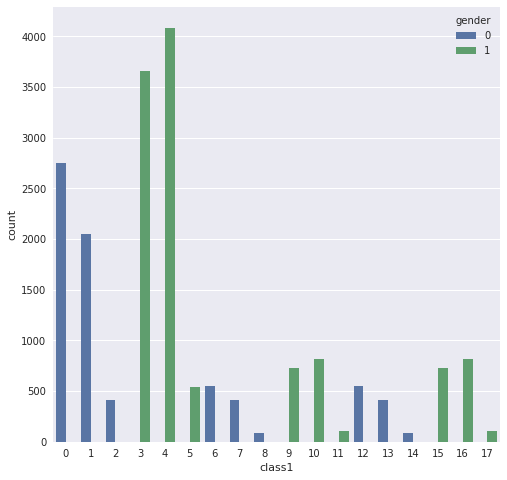

In [18]:
plt.figure(figsize=(8, 8))
sns.countplot('class1', hue='gender', data=train_data)

In [19]:
pd.crosstab(train_data.class1, train_data['gender']).style.background_gradient(cmap='RdYlGn_r')

gender,0,1
class1,,
0,2745,0
1,2050,0
2,415,0
3,0,3660
4,0,4085
5,0,545
6,549,0
7,410,0
8,83,0


In [20]:
train_data['class1'].value_counts().sort_index().to_frame()

,class1
0,2745
1,2050
2,415
3,3660
4,4085
5,545
6,549
7,410
8,83
9,732
